In [1]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

In [3]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info

In [4]:
class EnhancedCNN(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Feature extraction with Convolutional Layers
        self.conv = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(0.25),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(0.25),
        )

        # Adaptive Pooling to reduce feature size and prepare for fully connected layers
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, out_channels),
        )

    def forward(self, x):
        # Forward pass through Convolutional layers
        x = self.conv(x)
        
        # Global Average Pooling
        x = self.global_pool(x)
        
        # Flattening
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc(x)
        return x


In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
class DDQN:
    def __init__(self, action_space, batch_size=256, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=1000, lr=0.001):
        self._n_observation = 4
        self._n_actions = action_space.n
        self._action_space = action_space
        self._batch_size = batch_size
        self._gamma = gamma
        self._eps_start = eps_start
        self._eps_end = eps_end
        self._eps_decay = eps_decay
        self._lr = lr
        self._total_steps = 0
        self._evaluate_loss = []
        self.network = EnhancedCNN(self._n_observation, self._n_actions).to(device)
        self.target_network = EnhancedCNN(self._n_observation, self._n_actions).to(device)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = optim.Adam(self.network.parameters(), lr=self._lr)
        self._memory = ReplayMemory(10000)

    def select_action(self, state, evaluation_phase=False):
        sample = random.random()
        eps_threshold = self._eps_end + (self._eps_start - self._eps_end) * math.exp(-1. * self._total_steps / self._eps_decay)
        self._total_steps += 1

        if evaluation_phase:
            with torch.no_grad():
                return self.target_network(state).max(1).indices.view(1, 1)
        elif sample > eps_threshold:
            with torch.no_grad():
                return self.network(state).max(1).indices.view(1, 1)
        else:
            # 가속(예: 3번 액션)을 더 자주 선택
            return torch.tensor([[random.choice([3])]], device=device, dtype=torch.long)
        
    def train(self):
        if len(self._memory) < self._batch_size:
            return

        transitions = self._memory.sample(self._batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.network(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self._batch_size, device=device)
        with torch.no_grad():
            # Double DQN: Using target network to get next actions
            next_actions = self.network(non_final_next_states).max(1).indices
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).gather(1, next_actions.unsqueeze(1)).squeeze()

        expected_state_action_values = (next_state_values * self._gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
        self.optimizer.step()

        self._evaluate_loss.append(loss.item())

    def copy_weights(self):
        #self.target_network.load_state_dict(self.network.state_dict())
        if self._total_steps % 200 == 0:  # 200 스텝마다 업데이트
            self.target_network.load_state_dict(self.network.state_dict())
            
    def get_loss(self):
        return self._evaluate_loss

    def save_model(self, i):
        torch.save(self.target_network.state_dict(), f'DDQN_new_model_weights_{i}.pth')

    def load_model(self, i):
        self.target_network.load_state_dict(torch.load(f'DDQN_new_model_weights_{i}.pth', map_location=device, weights_only=False))


In [7]:
def plot_statistics(x, y, title, x_axis, y_axis):
    plt.plot(x, y)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_")}.png')  # 공백 대신 밑줄 사용
    plt.show()
     

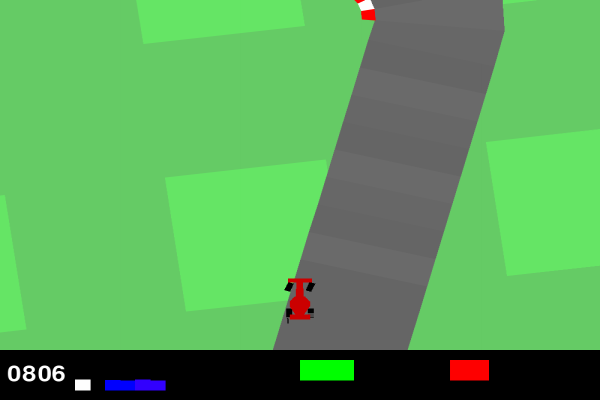

799.4547038327403


In [13]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)
n_actions = eval_env.action_space
agent = DDQN(n_actions)
agent.load_model(1000)

frames = []
scores = 0
s, _ = eval_env.reset()

eval_env.np_random = np.random.default_rng(42)

done, ret = False, 0

from PIL import Image as PILImage
def render2img(_img): return PILImage.fromarray(_img, "RGB")
handle = display(None, display_id=True)
while not done:
    _render = eval_env.render()
    handle.update(render2img(_render))
    frames.append(_render)
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True)
    discrete_action = a.item() % 5
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    s = s_prime
    ret += r
    done = terminated or truncated
    if terminated:
      print(terminated)
      
scores += ret

print(scores)